# Get data

In [1]:
# Only run if you need new data
'''

from entsoe import EntsoePandasClient
import pandas as pd

# Initialize client
client = EntsoePandasClient(api_key='YOUR_KEY') 

start = pd.Timestamp('2022-06-01', tz='Europe/Brussels')
end = pd.Timestamp('2022-06-30 23:59', tz='Europe/Brussels')

# List of all European country codes (based on ENTSO-E EIC codes)
european_zones = [
    'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE_LU', 'DK', 'EE', 'ES',
    'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 
    'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR'
]

# Initialize dictionary to store the flows
cross_border_flows = {}

# Loop through all possible pairs (excluding identical pairs)
for from_zone in european_zones:
    for to_zone in european_zones:
        if from_zone != to_zone:
            try:
                flow = client.query_crossborder_flows(from_zone, to_zone, start=start, end=end)
                cross_border_flows[(from_zone, to_zone)] = flow
                print(f"Retrieved flow data from {from_zone} to {to_zone}")
            except Exception as e:
                print(f"Failed to retrieve flow from {from_zone} to {to_zone}: {e}")

# Convert the dictionary to a DataFrame for better analysis
flows_df = pd.DataFrame({f"{k[0]}-{k[1]}": v for k, v in cross_border_flows.items()})

# Optionally, save to CSV
flows_df.to_csv("cross_border_flows_june_2022.csv")

'''

'\n\nfrom entsoe import EntsoePandasClient\nimport pandas as pd\n\n# Initialize client\nclient = EntsoePandasClient(api_key=\'YOUR_KEY\') \n\nstart = pd.Timestamp(\'2022-06-01\', tz=\'Europe/Brussels\')\nend = pd.Timestamp(\'2022-06-30 23:59\', tz=\'Europe/Brussels\')\n\n# List of all European country codes (based on ENTSO-E EIC codes)\neuropean_zones = [\n    \'AL\', \'AT\', \'BA\', \'BE\', \'BG\', \'CH\', \'CY\', \'CZ\', \'DE_LU\', \'DK\', \'EE\', \'ES\',\n    \'FI\', \'FR\', \'GB\', \'GR\', \'HR\', \'HU\', \'IE\', \'IS\', \'IT\', \'LT\', \'LU\', \'LV\', \n    \'ME\', \'MK\', \'MT\', \'NL\', \'NO\', \'PL\', \'PT\', \'RO\', \'RS\', \'SE\', \'SI\', \'SK\', \'TR\'\n]\n\n# Initialize dictionary to store the flows\ncross_border_flows = {}\n\n# Loop through all possible pairs (excluding identical pairs)\nfor from_zone in european_zones:\n    for to_zone in european_zones:\n        if from_zone != to_zone:\n            try:\n                flow = client.query_crossborder_flows(from_zone, t

# Analysis

There are 3 tests:
1. Visualize hourly flows
2. Interpolate data to make the plot more smooth
3. Calculate an overall flow direction and visualize it

We consider the hourly aggregated cross-border flows. In the current repo, data for June 2022 and June 2025 are downloaded.

## Load data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import animation
from scipy.interpolate import interp1d
import geodatasets
import pvlib

#filename = 'cross_border_flows_june_2022'
filename = 'cross_border_flows_june_2025'
# Load the data
flows_df = pd.read_csv(filename+'.csv', parse_dates=True, index_col=0)

# Compute net flows (combine A→B and B→A into one net flow)
net_flows = {}

for col in flows_df.columns:
    zone_a, zone_b = col.split('-')
    key = tuple(sorted([zone_a, zone_b]))
    
    if key not in net_flows:
        reverse_col = f"{zone_b}-{zone_a}"
        if reverse_col in flows_df.columns:
            net_flows[key] = flows_df[col] - flows_df[reverse_col]
        else:
            net_flows[key] = flows_df[col]
    # If reverse already handled, skip to avoid double counting

# Create DataFrame from net flows
net_flows_df = pd.DataFrame({f"{k[0]}-{k[1]}": v for k, v in net_flows.items()})

# Remove Malta
net_flows_df = net_flows_df[[col for col in net_flows_df.columns if 'MT' not in col]]

# Load Europe map using geodatasets
europe = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Define zone coordinates
zone_coords = {
    'AL': (20.0, 41.3), 'AT': (14.5, 47.6), 'BA': (17.7, 43.9), 'BE': (4.5, 50.8),
    'BG': (25.5, 42.7), 'CH': (8.2, 46.8), 'CY': (33.4, 35.1), 'CZ': (15.5, 49.8),
    'DE_LU': (10.4, 51.2), 'DK': (9.5, 56.0), 'EE': (25.0, 58.6), 'ES': (-3.7, 40.4),
    'FI': (25.7, 61.9), 'FR': (2.2, 46.2), 'GB': (-1.2, 52.3), 'GR': (23.7, 39.1),
    'HR': (16.0, 45.8), 'HU': (19.0, 47.2), 'IE': (-8.2, 53.4), 'IT': (12.5, 41.9),
    'LT': (24.0, 55.2), 'LU': (6.1, 49.8), 'LV': (25.0, 57.0), 'ME': (19.3, 42.7),
    'MK': (21.4, 41.6), 'NL': (5.5, 52.1), 'NO': (8.5, 60.5), 'PL': (19.1, 52.1),
    'PT': (-8.2, 39.4), 'RO': (25.0, 45.9), 'RS': (20.5, 44.8), 'SE': (18.6, 60.1),
    'SI': (14.5, 46.1), 'SK': (19.5, 48.7), 'TR': (32.8, 39.0)

}

# Prepare sun intensity grid using clearsky model
lon_grid = np.linspace(-25, 45, 10)
lat_grid = np.linspace(34, 72, 10)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
ghi_grid = np.zeros((24, lat_grid.size, lon_grid.size))
times = pd.date_range('2025-06-15', periods=24, freq='h', tz='Europe/Brussels')

# Calculate clear-sky GHI
for hour in range(24):
    for i, lat in enumerate(lat_grid):
        for j, lon in enumerate(lon_grid):
            location = pvlib.location.Location(lat, lon, tz='Europe/Brussels')
            clearsky = location.get_clearsky(times)
            ghi_value = clearsky.iloc[hour]['ghi']
            ghi_grid[hour, i, j] = ghi_value

## Test 1

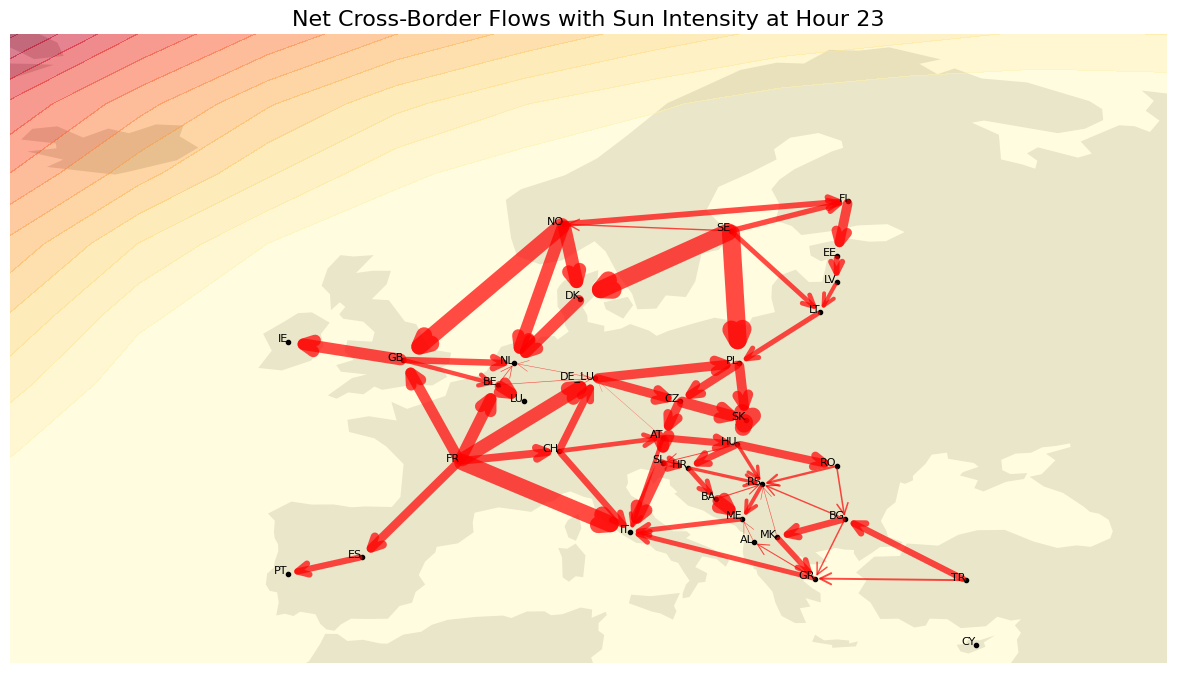

In [49]:
# Normalize flows
normalized_flows_df = net_flows_df.div(net_flows_df.abs().max(axis=0), axis=1)

# Group by hour and average
average_hourly_flows = normalized_flows_df.groupby(normalized_flows_df.index.hour).mean()

# Plotting animation
fig, ax = plt.subplots(figsize=(12, 10))

def update(hour):
    ax.clear()
    europe.plot(ax=ax, color='lightgrey')

    hourly_flows = average_hourly_flows.loc[hour]
    for pair, flow_value in hourly_flows.items():
        zone_a, zone_b = pair.split('-')
        if zone_a in zone_coords and zone_b in zone_coords:
            coord_a = zone_coords[zone_a]
            coord_b = zone_coords[zone_b]
            
            # Determine arrow direction based on flow sign
            if flow_value > 0:
                from_coord, to_coord = coord_a, coord_b
            else:
                from_coord, to_coord = coord_b, coord_a
            
            flow_magnitude = abs(flow_value) * 15  # Adjust scale as needed
            color = 'red' if flow_value > 0 else 'red'
            
            ax.annotate(
                '', xy=to_coord, xytext=from_coord,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=flow_magnitude,
                                alpha=0.7, mutation_scale=20)
            )

    # Overlay GHI
    ghi_hour = ghi_grid[hour]
    contour = ax.contourf(lon_mesh, lat_mesh, ghi_hour, levels=15, cmap='YlOrRd', alpha=0.5)

    # Plot zone markers and labels
    for zone, coord in zone_coords.items():
        ax.plot(coord[0], coord[1], marker='o', color='black', markersize=3)
        ax.text(coord[0], coord[1], zone, fontsize=8, ha='right')

    ax.set_xlim(-25, 45)
    ax.set_ylim(34, 72)
    ax.set_title(f'Net Cross-Border Flows with Sun Intensity at Hour {hour}', fontsize=16)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=24, interval=400, repeat=True)
plt.tight_layout(pad=0)
ani.save(f'figs/{filename}.gif', writer='pillow')
plt.show()


## Test 2

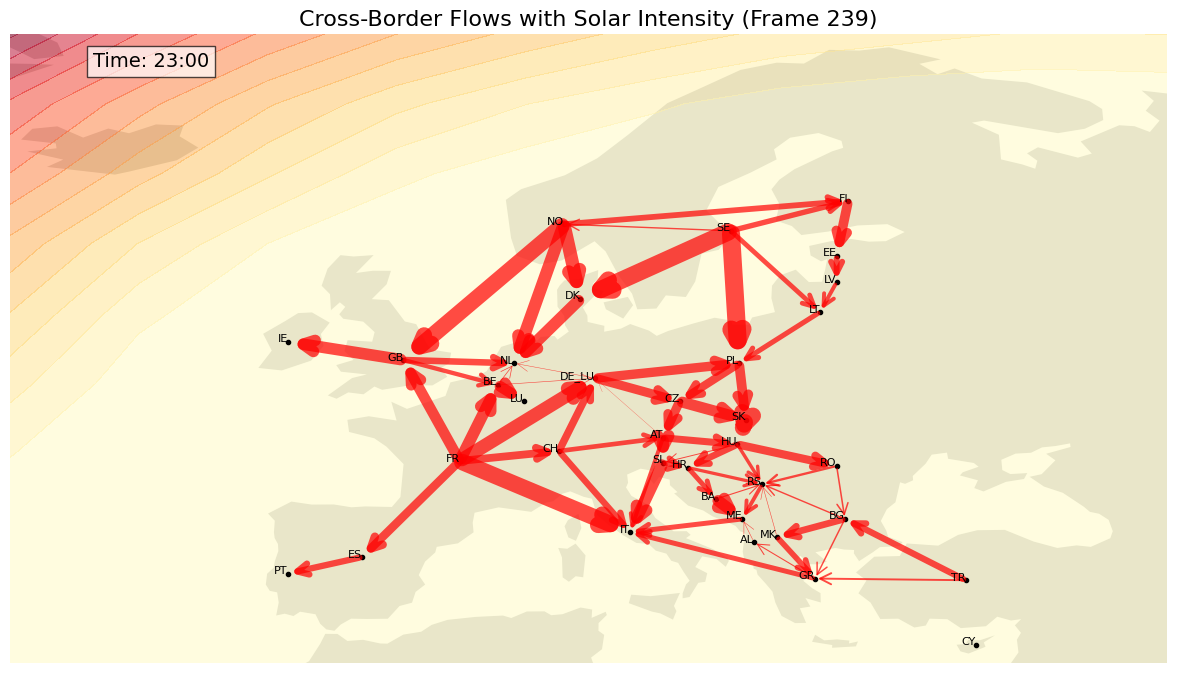

In [50]:
# Normalize flows so the largest value for each line is 1
normalized_flows_df = net_flows_df.div(net_flows_df.abs().max(axis=0), axis=1)

# Interpolate flows and GHI for smoother transitions
# Group by hour and take mean
average_hourly_flows = normalized_flows_df.groupby(normalized_flows_df.index.hour).mean()

# Interpolating to 240 frames (10 frames per hour)
interpolated_hours = np.linspace(0, 23, 240)  # 10 frames per hour
# Interpolating flows
interpolated_flows = pd.DataFrame(
    interp1d(average_hourly_flows.index, average_hourly_flows.values, axis=0, kind='linear')(interpolated_hours),
    columns=average_hourly_flows.columns
)
# Interpolating GHI
ghi_interp_func = interp1d(range(24), ghi_grid, axis=0, kind='linear')
interpolated_ghi_grid = ghi_interp_func(interpolated_hours)

# Create the animation
fig, ax = plt.subplots(figsize=(12, 10))

def update(frame):
    ax.clear()
    # Plot Europe map
    europe.plot(ax=ax, color='lightgrey')

    # Draw flow lines with arrows for the current frame
    hourly_flows = interpolated_flows.iloc[frame]
    for pair, flow_value in hourly_flows.items():
        zone_a, zone_b = pair.split('-')
        if zone_a in zone_coords and zone_b in zone_coords:
            coord_a = zone_coords[zone_a]
            coord_b = zone_coords[zone_b]
            
            # Minimal change: decide arrow direction based on flow sign
            if flow_value > 0:
                from_coord, to_coord = coord_a, coord_b
            else:
                from_coord, to_coord = coord_b, coord_a
            
            flow_magnitude = abs(flow_value) * 15
            color = 'red' if flow_value > 0 else 'red'
            
            ax.annotate(
                '', xy=to_coord, xytext=from_coord,
                arrowprops=dict(arrowstyle='->', color=color, linewidth=flow_magnitude, alpha=0.7, mutation_scale=20)
            )

    # Overlay sun intensity as contour lines
    ghi_hour = interpolated_ghi_grid[frame]
    contour = ax.contourf(lon_mesh, lat_mesh, ghi_hour, levels=15, cmap='YlOrRd', alpha=0.5)

    # Add zone points
    for zone, coord in zone_coords.items():
        ax.plot(coord[0], coord[1], marker='o', color='black', markersize=3)
        ax.text(coord[0], coord[1], zone, fontsize=8, ha='right')

    # Add time of day as text
    hour = int(interpolated_hours[frame]) % 24
    ax.text(-20, 70, f'Time: {hour:02d}:00', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

    # Formatting with zoom on Europe
    ax.set_xlim(-25, 45)
    ax.set_ylim(34, 72)
    ax.set_title(f'Cross-Border Flows with Solar Intensity (Frame {frame})', fontsize=16)
    ax.axis('off')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=240, interval=60, repeat=True)
plt.tight_layout(pad=0)

# Save the animation
ani.save(f'figs/{filename}_interpolated.gif', writer='pillow')

plt.show()


## Test 3

### Some NaN issue with NL-NO

In [51]:
# Normalize flows so the largest value for each line is 1
normalized_flows_df = net_flows_df.div(net_flows_df.abs().max(axis=0), axis=1)

# Interpolate flows and GHI for smoother transitions
average_hourly_flows = normalized_flows_df.groupby(normalized_flows_df.index.hour).mean()

# Interpolating to 240 frames (10 frames per hour)
interpolated_hours = np.linspace(0, 23, 240)
# Interpolating flows
interpolated_flows = pd.DataFrame(
    interp1d(average_hourly_flows.index, average_hourly_flows.values, axis=0, kind='linear')(interpolated_hours),
    columns=average_hourly_flows.columns
)


# Total number of NaNs
print("Total NaNs:", interpolated_flows.isna().sum().sum())
# Get all row, column locations where NaNs occur
nan_locations = interpolated_flows.isna()

# Extract (row index, column name) for every NaN
nan_cells = [(row, col) for row, row_data in nan_locations.iterrows() for col, is_nan in row_data.items() if is_nan]

# Display the list of NaN cell locations
for loc in nan_cells:
    print(f"NaN at row: {loc[0]}, column: {loc[1]}")


Total NaNs: 0


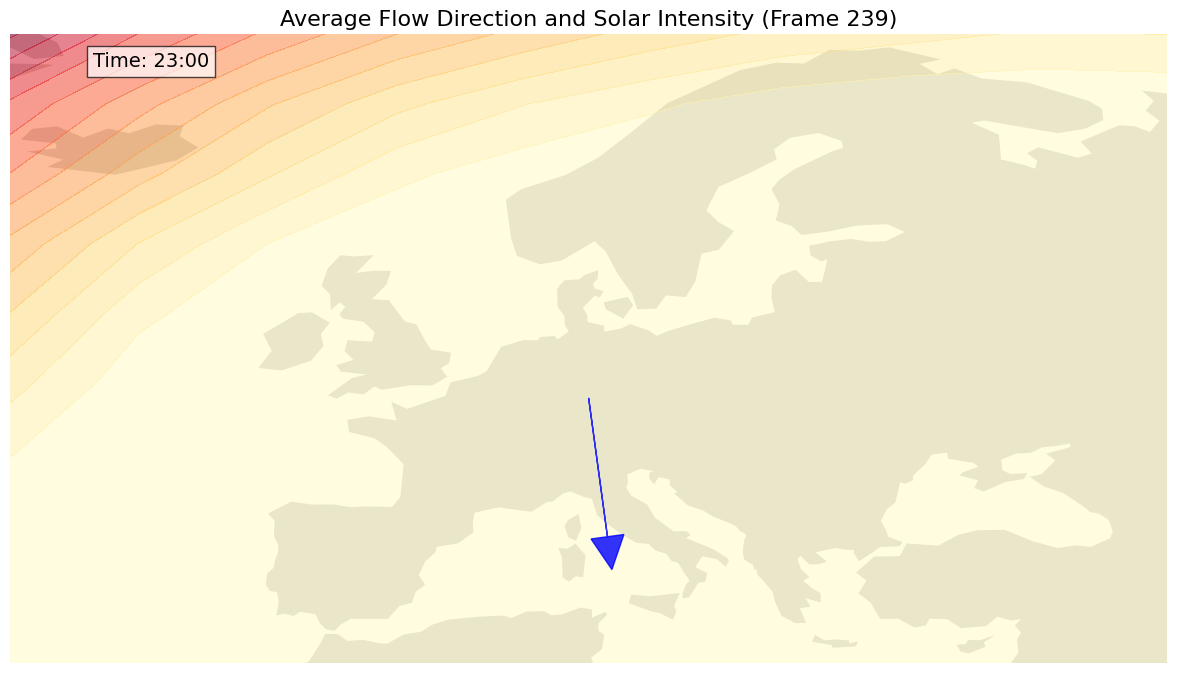

In [52]:
# Normalize flows so the largest value for each line is 1
normalized_flows_df = net_flows_df.div(net_flows_df.abs().max(axis=0), axis=1)

# Interpolate flows and GHI for smoother transitions
average_hourly_flows = normalized_flows_df.groupby(normalized_flows_df.index.hour).mean()

# Interpolating to 240 frames (10 frames per hour)
interpolated_hours = np.linspace(0, 23, 240)
# Interpolating flows
interpolated_flows = pd.DataFrame(
    interp1d(average_hourly_flows.index, average_hourly_flows.values, axis=0, kind='linear')(interpolated_hours),
    columns=average_hourly_flows.columns
)
# Some nans. We fill them
interpolated_flows = interpolated_flows.fillna(0)

# Interpolating GHI
ghi_interp_func = interp1d(range(24), ghi_grid, axis=0, kind='linear')
interpolated_ghi_grid = ghi_interp_func(interpolated_hours)

# Calculate average flow direction per frame
def calculate_average_flow_directions(interpolated_flows, zone_coords):
    average_directions = []
    magnitudes = []

    for frame in range(len(interpolated_flows)):
        flows = interpolated_flows.iloc[frame]
        total_dx = 0
        total_dy = 0

        for pair, flow_value in flows.items():
            zone_a, zone_b = pair.split('-')
            if zone_a in zone_coords and zone_b in zone_coords:
                coord_a = np.array(zone_coords[zone_a])
                coord_b = np.array(zone_coords[zone_b])
                
                # Decide direction based on flow sign
                if flow_value > 0:
                    from_coord, to_coord = coord_a, coord_b
                else:
                    from_coord, to_coord = coord_b, coord_a
                
                direction_vector = to_coord - from_coord
                direction_vector_normalized = direction_vector / np.linalg.norm(direction_vector)
                total_dx += direction_vector_normalized[0] * abs(flow_value)
                total_dy += direction_vector_normalized[1] * abs(flow_value)

        angle_radians = np.arctan2(total_dy, total_dx)
        magnitude = np.hypot(total_dx, total_dy)
        average_directions.append(angle_radians)
        magnitudes.append(magnitude)

    return average_directions, magnitudes

average_directions, magnitudes = calculate_average_flow_directions(interpolated_flows, zone_coords)

# Create the animation
fig, ax = plt.subplots(figsize=(12, 10))

def update(frame):
    ax.clear()
    europe.plot(ax=ax, color='lightgrey')

    # Overlay sun intensity
    ghi_hour = interpolated_ghi_grid[frame]
    contour = ax.contourf(lon_mesh, lat_mesh, ghi_hour, levels=15, cmap='YlOrRd', alpha=0.5)

    # Draw average flow direction arrow
    center_x, center_y = 10, 50  # Center over Europe
    direction = average_directions[frame]
    magnitude = magnitudes[frame] * 1  # Scaled for visualization
    dx = np.cos(direction) * magnitude
    dy = np.sin(direction) * magnitude

    ax.arrow(center_x, center_y, dx, dy, head_width=2, head_length=2, fc='blue', ec='blue', alpha=0.8)

    # Add time of day as text
    hour = int(interpolated_hours[frame]) % 24
    ax.text(-20, 70, f'Time: {hour:02d}:00', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

    # Formatting
    ax.set_xlim(-25, 45)
    ax.set_ylim(34, 72)
    ax.set_title(f'Average Flow Direction and Solar Intensity (Frame {frame})', fontsize=16)
    ax.axis('off')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=240, interval=60, repeat=True)
plt.tight_layout(pad=0)

# Save the animation
ani.save(f'figs/{filename}_aggregate.gif', writer='pillow')

plt.show()
